In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import ujipenchars2
from drawing import Drawing
from preprocessing import DrawingToBoxScaler, DrawingResampler
from dtw import dtw, rsi_dtw, rsi_dtw_distance_matrix_symmetric, dtw_distance_matrix_symmetric
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from classifier_pickle import KNNDTWPickle, KNNRSIDTWPickle

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(800, 400)

In [3]:
# Preprocessing
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

drawing_resampler = DrawingResampler(40)
data = drawing_resampler.transform(data)

# Tenzor sa svim podacima
stacked_data = np.stack([np.vstack(drawing.strokes) for drawing in data])

# k-NN (DTW)

In [4]:
# Matrica s DTW udaljenostima
DTW = dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx])

In [5]:
def knn_loocv(D, train_idx, test_idx, max_neighbors):
    n_neighbors = list(range(1, max_neighbors + 1))
    scores = []
    best_score = 0
    best_cls = None
    D = D[:]
    np.fill_diagonal(D, 2*np.max(D))
    for i in n_neighbors:
        cls = KNeighborsClassifier(n_neighbors=i, weights='uniform', algorithm='brute', metric='precomputed')
        cls.fit(D[np.ix_(train_idx, train_idx)], labels[train_idx])
        scores.append(cls.score(D[np.ix_(train_idx, train_idx)], labels[train_idx]))
        if scores[-1] > best_score:
            best_score = scores[-1]
            best_cls = cls
    return best_cls, best_cls.score(D[np.ix_(test_idx, train_idx)], labels[test_idx]), n_neighbors, scores

n_neighbors = 1
Točnost na test: 0.98


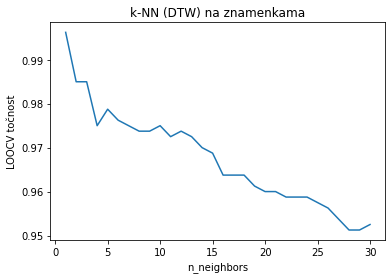

In [6]:
knn_dtw, test_score, n_neighbors, scores = knn_loocv(DTW, train_idx, test_idx, 30)

print('n_neighbors =', knn_dtw.get_params()['n_neighbors'])
print('Točnost na test:', test_score)

plt.plot(n_neighbors, scores)
plt.title('k-NN (DTW) na znamenkama')
plt.xlabel('n_neighbors')
plt.ylabel('LOOCV točnost')
plt.show()

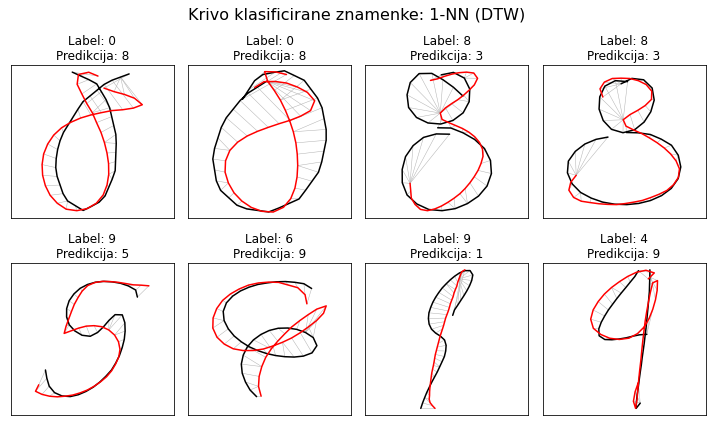

In [7]:
# Krivo klasificirane znamenke
#   crno = krivo klasificirani primjer
#   crveno = najbliži susjed

def plot_dtw(drawing1: Drawing, drawing2: Drawing, title):
    stroke1 = np.vstack(drawing1.strokes)
    stroke2 = np.vstack(drawing2.strokes)
    distance, matching = dtw(stroke1, stroke2)
    plt.title(title)
    for i in matching:
        plt.plot([stroke1[i[0], 0], stroke2[i[1], 0]], [stroke1[i[0], 1], stroke2[i[1], 1]], color='0.7', linewidth=0.5)
    for stroke in drawing1.strokes:
        plt.plot(stroke[:,0], stroke[:,1], color='black', solid_capstyle='round')
    for stroke in drawing2.strokes:
        plt.plot(stroke[:,0], stroke[:,1], color='red', solid_capstyle='round')
    axes = plt.gca().axes
    axes.xaxis.set_ticks([])
    axes.yaxis.set_ticks([])
    plt.axis('equal')

neighbors = knn_dtw.kneighbors(DTW[np.ix_(test_idx, train_idx)])[1][:, 0]
p = labels[neighbors]
wrong_idx = np.where(p != labels[test_idx])[0]
n = wrong_idx.shape[0]
rows = (n + 3) // 4
plt.figure(figsize=(10, rows * 3))
plt.suptitle('Krivo klasificirane znamenke: 1-NN (DTW)', fontsize=16)
for i, idx in enumerate(wrong_idx):
    plt.subplot(rows, 4, i + 1)
    plot_dtw(data[len(train)+idx], data[neighbors[idx]], f'Label: {labels[test_idx][idx]}\nPredikcija: {p[idx]}')
    
plt.tight_layout()

In [8]:
# Spremamo najbolji DTW model za znamenke
KNNDTWPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=knn_dtw,
).save('models/KNN-DTW.pickle')

# k-NN (RSIDTW)

In [9]:
# Matrica s RSIDTW udaljenostima
RSIDTW = rsi_dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx], 10)

n_neighbors = 1
Točnost na test: 0.9825


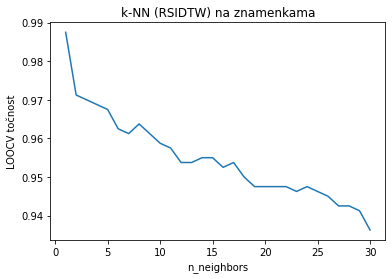

In [10]:
knn_rsidtw, test_score, n_neighbors, scores = knn_loocv(RSIDTW, train_idx, test_idx, 30)

print('n_neighbors =', knn_rsidtw.get_params()['n_neighbors'])
print('Točnost na test:', test_score)

plt.plot(n_neighbors, scores)
plt.title('k-NN (RSIDTW) na znamenkama')
plt.xlabel('n_neighbors')
plt.ylabel('LOOCV točnost')
plt.show()

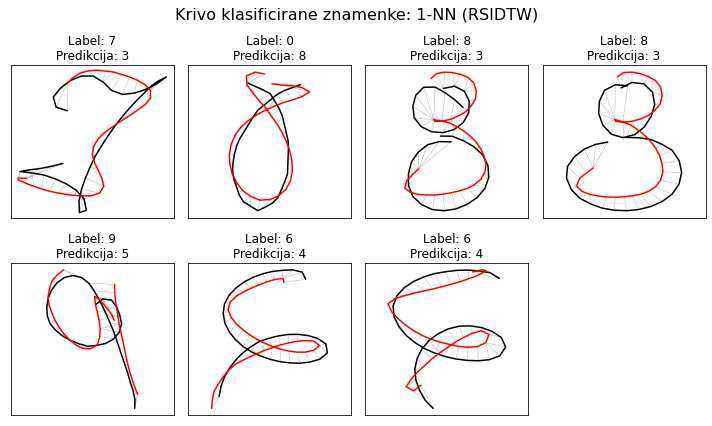

In [11]:
# Krivo klasificirane znamenke
#   crno = krivo klasificirani primjer
#   crveno = najbliži susjed

def plot_dtw(drawing1: Drawing, drawing2: Drawing, title):
    stroke1 = np.vstack(drawing1.strokes)
    stroke2 = np.vstack(drawing2.strokes)
    distance, matching = dtw(stroke1, stroke2)
    plt.title(title)
    for i in matching:
        plt.plot([stroke1[i[0], 0], stroke2[i[1], 0]], [stroke1[i[0], 1], stroke2[i[1], 1]], color='0.7', linewidth=0.5)
    for stroke in drawing1.strokes:
        plt.plot(stroke[:,0], stroke[:,1], color='black', solid_capstyle='round')
    for stroke in drawing2.strokes:
        plt.plot(stroke[:,0], stroke[:,1], color='red', solid_capstyle='round')
    axes = plt.gca().axes
    axes.xaxis.set_ticks([])
    axes.yaxis.set_ticks([])
    plt.axis('equal')

neighbors = knn_rsidtw.kneighbors(RSIDTW[np.ix_(test_idx, train_idx)])[1][:, 0]
p = labels[neighbors]
wrong_idx = np.where(p != labels[test_idx])[0]
n = wrong_idx.shape[0]
rows = (n + 3) // 4
plt.figure(figsize=(10, rows * 3))
plt.suptitle('Krivo klasificirane znamenke: 1-NN (RSIDTW)', fontsize=16)
for i, idx in enumerate(wrong_idx):
    plt.subplot(rows, 4, i + 1)
    d1 = data[len(train)+idx]
    d2 = data[neighbors[idx]]
    _, _, rotation, translation = rsi_dtw(np.vstack([s for s in d2.strokes]), np.vstack([s for s in d1.strokes]), 10)
    plot_dtw(
        d1,
        Drawing(label=d2.label, strokes=[s @ rotation + translation for s in d2.strokes]),
        f'Label: {labels[test_idx][idx]}\nPredikcija: {p[idx]}',
    )
plt.tight_layout()

In [12]:
# Spremamo najbolji RSIDTW model za znamenke
KNNRSIDTWPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=knn_rsidtw,
    n_iter=10,
).save('models/KNN-RSIDTW.pickle')

# k-NN (DTW) - velika slova engleske abecede

In [13]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.ascii_uppercase)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(2080, 1040)

n_neighbors = 1
Točnost na test: 0.9125


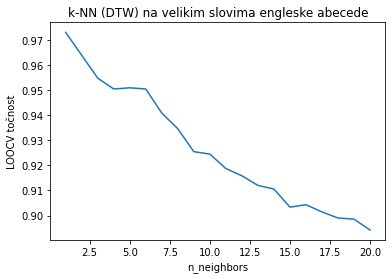

In [14]:
# Preprocessing
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

drawing_resampler = DrawingResampler(100) # više -> točnije ali i sporije
data = drawing_resampler.transform(data)

# Tenzor sa svim podacima
stacked_data = np.stack([np.vstack(drawing.strokes) for drawing in data])

# Matrica s DTW udaljenostima
DTW = dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx])

knn_dtw, test_score, n_neighbors, scores = knn_loocv(DTW, train_idx, test_idx, 20)

print('n_neighbors =', knn_dtw.get_params()['n_neighbors'])
print('Točnost na test:', test_score)

plt.plot(n_neighbors, scores)
plt.title('k-NN (DTW) na velikim slovima engleske abecede')
plt.xlabel('n_neighbors')
plt.ylabel('LOOCV točnost')
plt.show()